#Util code

In [ ]:
!nvidia-smi

Sun Nov  1 17:51:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/Projet6/dataset.zip" "."

In [ ]:
!unzip -uq "dataset.zip"

In [ ]:
'''
!wget -O 'images.tar' 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
!wget -O 'annotation.tar' 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'
!wget -O 'lists.tar' 'http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar'
'''

In [ ]:
'''
!tar -xvf 'images.tar'
!tar -xvf 'annotation.tar'
!tar -xvf 'lists.tar'
'''

In [ ]:
'''
trainList = scipy.io.loadmat('train_list.mat')
testList = scipy.io.loadmat('test_list.mat')
!mkdir "train"
!mkdir "validation"
trainList["annotation_list"][0][0][0]
os.path.exists("train/n02085620-Chihuahua")
for annotation in tqdm(trainList["annotation_list"]):
  annotation = annotation[0][0]
  root = "train/" + annotation.split('/')[0]
  if os.path.exists(root) == False: os.mkdir(root)
  copyfile('Images/'+annotation+'.jpg', 'train/'+annotation+'.jpg')
for annotation in tqdm(testList["annotation_list"]):
  annotation = annotation[0][0]
  root = "validation/" + annotation.split('/')[0]
  if os.path.exists(root) == False: os.mkdir(root)
  copyfile('Images/'+annotation+'.jpg', 'validation/'+annotation+'.jpg')
'''

#Creating Image datagenerators

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.io
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from shutil import copyfile
import os

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size = (250, 250),
        batch_size = 128,
        class_mode = "categorical")
validation_generator = test_datagen.flow_from_directory(
        'dataset/validation',
        target_size = (250, 250),
        batch_size = 128,
        class_mode = 'categorical')

Found 12000 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


#Creating first model

In [ ]:
def createModel(input_shape=(250, 250, 3), convFilters=[32, 64, 128, 256], 
                fcnNeurons=[256, 256, 120], kernel=(3, 3), strides=(2, 2), pool_size=(2,2), activation='relu', optimizer='adam'):
  
  model = tf.keras.Sequential()

  #block0: Convolutional (Input)
  model.add(tf.keras.layers.Conv2D(convFilters[0], kernel, strides=strides, activation=activation, input_shape=input_shape))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

  #blocki: Convolutional
  for nFilters in convFilters[1:]:
    model.add(tf.keras.layers.Conv2D(nFilters, kernel, activation=activation))
    model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size))

  #Flatten the filters
  model.add(tf.keras.layers.Flatten())

  #blocki: Fully connected
  for nNeuron in fcnNeurons[:-1]:
    model.add(tf.keras.layers.Dense(nNeuron, activation=activation))
  
  #blockn: Fully connected (Output)
  model.add(tf.keras.layers.Dense(fcnNeurons[-1], activation='softmax'))
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")

  return model

In [ ]:
model1 = createModel(convFilters=[64, 64, 128, 256], fcnNeurons=[512, 256, 128, 120])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

In [ ]:
model1.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=5,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
94/94 [==============================] - 198s 2s/step - loss: 4.7890 - accuracy: 0.0062 - val_loss: 4.7875 - val_accuracy: 0.0091
Epoch 2/5
94/94 [==============================] - 198s 2s/step - loss: 4.7881 - accuracy: 0.0084 - val_loss: 4.7875 - val_accuracy: 0.0059
Epoch 3/5
94/94 [==============================] - 196s 2s/step - loss: 4.7881 - accuracy: 0.0068 - val_loss: 4.7875 - val_accuracy: 0.0066
Epoch 4/5
94/94 [==============================] - 195s 2s/step - loss: 4.7880 - accuracy: 0.0056 - val_loss: 4.7874 - val_accuracy: 0.0084
Epoch 5/5
94/94 [==============================] - 195s 2s/step - loss: 4.7879 - accuracy: 0.0068 - val_loss: 4.7875 - val_accuracy: 0.0080


#Transfer learning

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50

In [ ]:
model = ResNet50()

In [ ]:
res50 = tf.keras.applications.ResNet50(weights='imagenet', include_top = False)
print(res50.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

In [ ]:
for i, layer in enumerate(res50.layers):
  print(i, layer.name)

0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
x = res50.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(120, activation ='softmax')(x)

In [ ]:
model = tf.keras.models.Model(inputs=res50.input, outputs=preds)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
for layer in model.layers[:175]:
  layer.trainable = False

In [ ]:
for layer in model.layers[175:]:
  layer.trainable = True

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory('dataset/train', 
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

Found 12000 images belonging to 120 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
test_generator = train_datagen.flow_from_directory('dataset/validation', 
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

Found 8580 images belonging to 120 classes.


In [ ]:
classes = {'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terrier': 31,
 'n02093859-Kerry_blue_terrier': 32,
 'n02093991-Irish_terrier': 33,
 'n02094114-Norfolk_terrier': 34,
 'n02094258-Norwich_terrier': 35,
 'n02094433-Yorkshire_terrier': 36,
 'n02095314-wire-haired_fox_terrier': 37,
 'n02095570-Lakeland_terrier': 38,
 'n02095889-Sealyham_terrier': 39,
 'n02096051-Airedale': 40,
 'n02096177-cairn': 41,
 'n02096294-Australian_terrier': 42,
 'n02096437-Dandie_Dinmont': 43,
 'n02096585-Boston_bull': 44,
 'n02097047-miniature_schnauzer': 45,
 'n02097130-giant_schnauzer': 46,
 'n02097209-standard_schnauzer': 47,
 'n02097298-Scotch_terrier': 48,
 'n02097474-Tibetan_terrier': 49,
 'n02097658-silky_terrier': 50,
 'n02098105-soft-coated_wheaten_terrier': 51,
 'n02098286-West_Highland_white_terrier': 52,
 'n02098413-Lhasa': 53,
 'n02099267-flat-coated_retriever': 54,
 'n02099429-curly-coated_retriever': 55,
 'n02099601-golden_retriever': 56,
 'n02099712-Labrador_retriever': 57,
 'n02099849-Chesapeake_Bay_retriever': 58,
 'n02100236-German_short-haired_pointer': 59,
 'n02100583-vizsla': 60,
 'n02100735-English_setter': 61,
 'n02100877-Irish_setter': 62,
 'n02101006-Gordon_setter': 63,
 'n02101388-Brittany_spaniel': 64,
 'n02101556-clumber': 65,
 'n02102040-English_springer': 66,
 'n02102177-Welsh_springer_spaniel': 67,
 'n02102318-cocker_spaniel': 68,
 'n02102480-Sussex_spaniel': 69,
 'n02102973-Irish_water_spaniel': 70,
 'n02104029-kuvasz': 71,
 'n02104365-schipperke': 72,
 'n02105056-groenendael': 73,
 'n02105162-malinois': 74,
 'n02105251-briard': 75,
 'n02105412-kelpie': 76,
 'n02105505-komondor': 77,
 'n02105641-Old_English_sheepdog': 78,
 'n02105855-Shetland_sheepdog': 79,
 'n02106030-collie': 80,
 'n02106166-Border_collie': 81,
 'n02106382-Bouvier_des_Flandres': 82,
 'n02106550-Rottweiler': 83,
 'n02106662-German_shepherd': 84,
 'n02107142-Doberman': 85,
 'n02107312-miniature_pinscher': 86,
 'n02107574-Greater_Swiss_Mountain_dog': 87,
 'n02107683-Bernese_mountain_dog': 88,
 'n02107908-Appenzeller': 89,
 'n02108000-EntleBucher': 90,
 'n02108089-boxer': 91,
 'n02108422-bull_mastiff': 92,
 'n02108551-Tibetan_mastiff': 93,
 'n02108915-French_bulldog': 94,
 'n02109047-Great_Dane': 95,
 'n02109525-Saint_Bernard': 96,
 'n02109961-Eskimo_dog': 97,
 'n02110063-malamute': 98,
 'n02110185-Siberian_husky': 99,
 'n02110627-affenpinscher': 100,
 'n02110806-basenji': 101,
 'n02110958-pug': 102,
 'n02111129-Leonberg': 103,
 'n02111277-Newfoundland': 104,
 'n02111500-Great_Pyrenees': 105,
 'n02111889-Samoyed': 106,
 'n02112018-Pomeranian': 107,
 'n02112137-chow': 108,
 'n02112350-keeshond': 109,
 'n02112706-Brabancon_griffon': 110,
 'n02113023-Pembroke': 111,
 'n02113186-Cardigan': 112,
 'n02113624-toy_poodle': 113,
 'n02113712-miniature_poodle': 114,
 'n02113799-standard_poodle': 115,
 'n02113978-Mexican_hairless': 116,
 'n02115641-dingo': 117,
 'n02115913-dhole': 118,
 'n02116738-African_hunting_dog': 119}

In [ ]:
list(classes.keys())[1].split('-')[1]

'Japanese_spaniel'

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(generator = train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs = 25)

In [ ]:
model.save_weights(filepath='model_version3_precision_0.9617')

In [ ]:
!cp '/content/model_version3_precision_0.9617.data-00000-of-00001' 'drive/My Drive/Projet6/'

In [ ]:
!cp '/content/model_version3_precision_0.9617.index' 'drive/My Drive/Projet6/'

In [ ]:
model.load_weights('/content/drive/My Drive/Projet6/model_version3_precision_0.9617')

In [ ]:
model.evaluate(test_generator, steps=test_generator.n//test_generator.batch_size)

268/268 [==============================] - 46s 170ms/step - loss: 1.9300 - accuracy: 0.7004


[1.9300224781036377, 0.7004430890083313]

[[0.00635663 0.00896189 0.00529061 0.01045132 0.00700961 0.00634079
  0.00638874 0.00415737 0.00343805 0.00966128 0.00782988 0.01021493
  0.00725273 0.00735984 0.00800671 0.00439456 0.0071403  0.00308648
  0.01361546 0.00564348 0.01331478 0.0068163  0.00689529 0.00736324
  0.0079838  0.01134637 0.01554223 0.01134543 0.00822309 0.00821948
  0.00628046 0.00773322 0.01062476 0.00777046 0.00596854 0.00781177
  0.00939287 0.00612048 0.00742113 0.01288177 0.00829926 0.00361351
  0.0142237  0.00622598 0.00872839 0.00720787 0.00602202 0.00776642
  0.00715085 0.00889875 0.00626799 0.0106871  0.00589681 0.00829328
  0.00762139 0.01265508 0.00684208 0.01149155 0.01293676 0.00584916
  0.00510435 0.00538491 0.00727219 0.01428648 0.0139814  0.00911408
  0.0064401  0.00577314 0.00841127 0.00906657 0.00728557 0.00474848
  0.01160763 0.00374297 0.01096117 0.00698833 0.00775066 0.00921542
  0.0075395  0.01127455 0.0078867  0.00576151 0.00567511 0.00547165
  0.01373828 0.00719746 0.00740115 0.00674276 0.

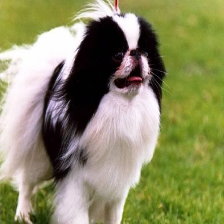

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image_path = "/content/dataset/validation/n02085782-Japanese_spaniel/n02085782_1039.jpg"
img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))
x = np.reshape(img, (1, 224, 224, 3))
prediction = model.predict(x)
print(prediction)
cv2_imshow(img)

In [ ]:
argclasse = np.argmax(prediction)
print(argclasse, prediction[0,0])

91 0.006356633


In [ ]:
classes = os.listdir("/content/dataset/validation/")
dictClasses = {}
for i in range(len(classes)):
  dictClasses[i] = classes[i]

#Features visualization

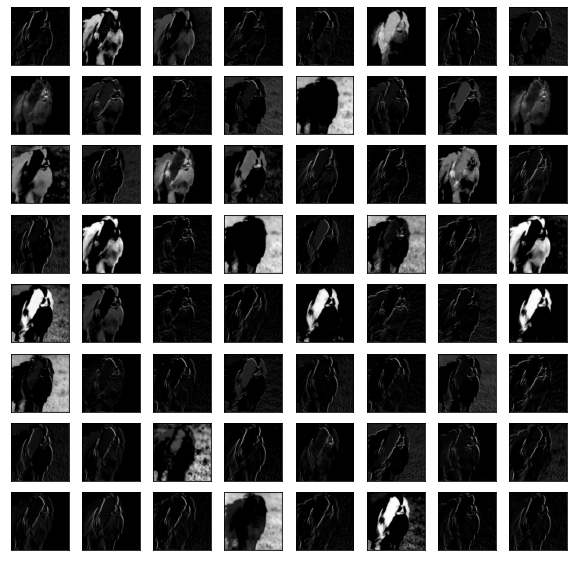

In [ ]:
# plot feature map of first conv layer for given image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
#model.summary()
# load the image with the required shape
img = load_img(image_path, target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

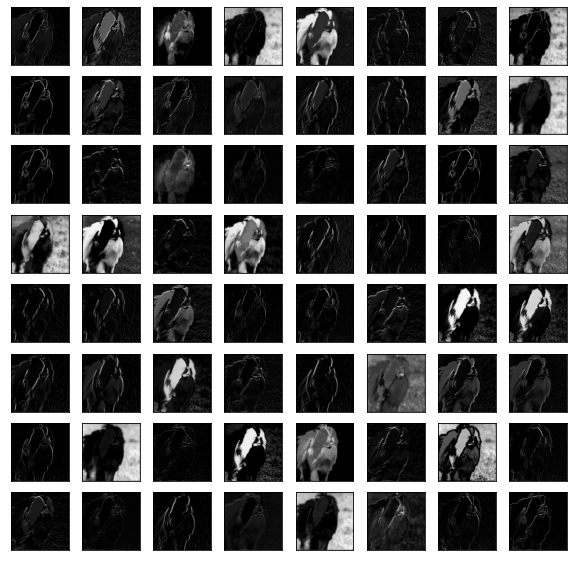

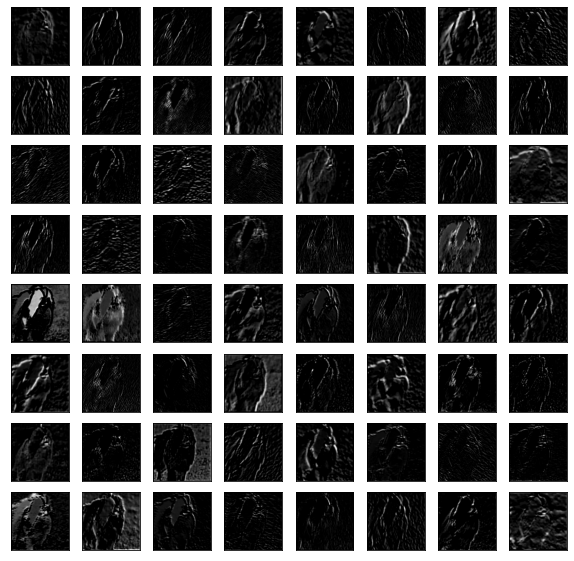

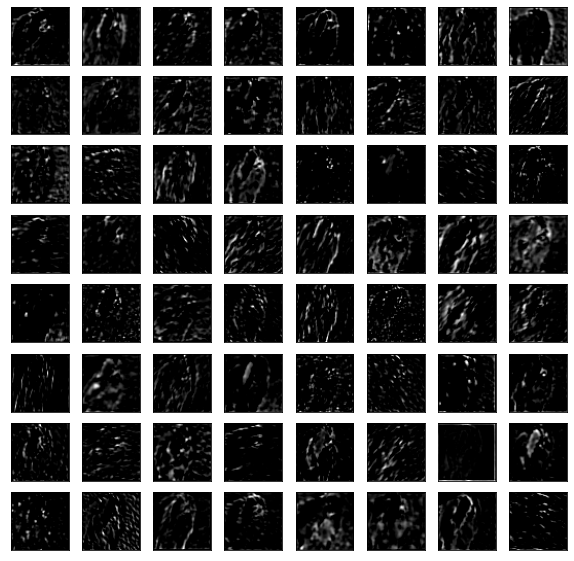

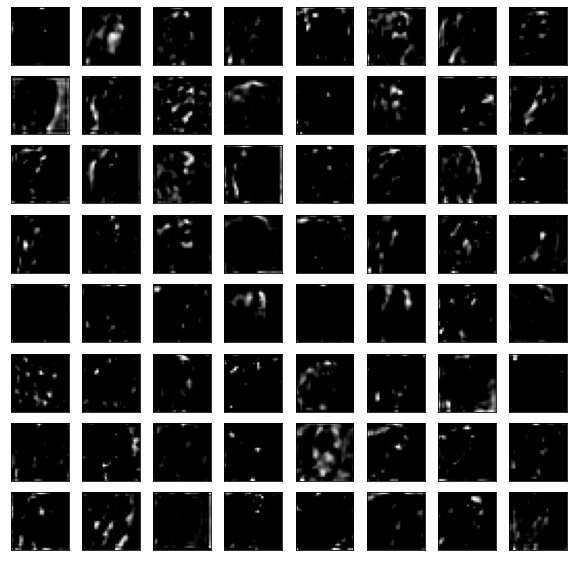

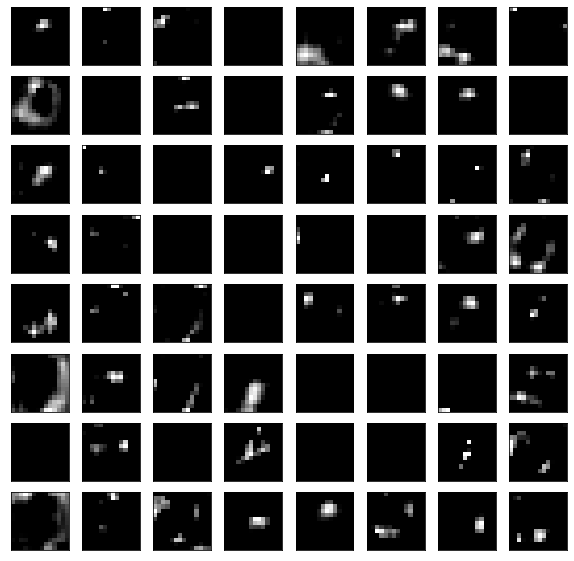

In [ ]:
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img(image_path, target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
  #plot all 64 maps in an 8x8 squares
  ix = 1
  for _ in range(square):
    for _ in range(square):
      #specify subplot and turn of axis
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      #plot filter channel in grayscale
      plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
  #show the figure
  fig = plt.gcf()
  fig.set_size_inches(10, 10)
  plt.show()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

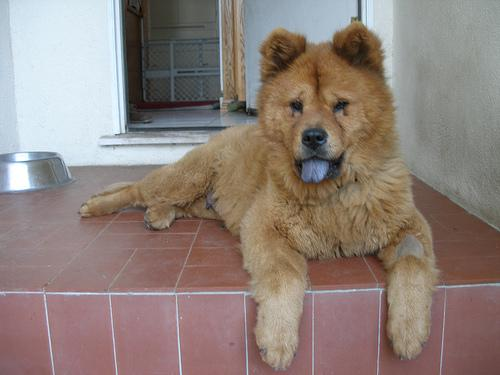

In [ ]:
img = cv2.imread("/content/dataset/validation/n02112137-chow/n02112137_1005.jpg")
cv2_imshow(img)

In [ ]:
!python "drive/My Drive/Projet6/dogClassification.py"

2020-11-01 16:55:18.327033: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-01 16:55:20.475183: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-01 16:55:20.487762: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-11-01 16:55:20.487807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (580decf3a433): /proc/driver/nvidia/version does not exist
2020-11-01 16:55:20.495346: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2250000000 Hz
2020-11-01 16:55:20.495595: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x236e840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-01 16:55:20.495626: I tensorflow/com